<a href="https://colab.research.google.com/github/FilipSagalara/MasterThesis_SNN_frameworks/blob/main/Norse_MNIST_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Timer
import time

class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time

    def get_execution_time(self):
        return self.execution_time


    

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Reproductibility


In [ ]:
#Reproductibility
torch.manual_seed(0)

We can simply install Norse through pip:

In [ ]:
!pip install --quiet norse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from norse.torch.functional import (
    lif_step,
    lift,
    lif_feed_forward_step,
    lif_current_encoder,
    LIFParameters,
)

N = 1  # number of neurons to consider
T = 100  # number of timesteps to integrate

p = LIFParameters()
v = torch.zeros(N)  # initial membrane voltage
input_current = 1.1 * torch.ones(N)

voltages = []

for ts in range(T):
    z, v = lif_current_encoder(input_current, v, p)
    voltages.append(v)

voltages = torch.stack(voltages)

In [ ]:
plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)

# Set batch size

In [ ]:
BATCH_SIZE = 256


In [ ]:
import torchvision
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 124947290.86it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 114603305.42it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40799552.81it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4204486.60it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
from norse.torch import ConstantCurrentLIFEncoder

In [ ]:
img, label = train_data[1]

plt.matshow(img[0])
plt.colorbar()
print(label)

In [ ]:
# T = 32
# example_encoder = ConstantCurrentLIFEncoder(T)


# example_input = example_encoder(img)
# example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
# t = example_spikes.indices()[0]
# n = example_spikes.indices()[1]

# plt.scatter(t, n, marker="|", color="black")
# plt.ylabel("Input Unit")
# plt.xlabel("Time [ms]")
# plt.show()

In [ ]:
from norse.torch import PoissonEncoder

This produces a more biological plausible input pattern, as can be seen below:

In [ ]:
from norse.torch import SpikeLatencyLIFEncoder

In [ ]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

In [ ]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [ ]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

# Set num of epochs

In [ ]:
EPOCHS = 1  # originally 2

In [ ]:
from tqdm.notebook import tqdm, trange



def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [ ]:
from sklearn.metrics import confusion_matrix
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0

    preds_ints = []
    true_ints = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Find predictions and true values
            class_to_preds_format = target.view_as(pred)
            for ix, class_num in enumerate(class_to_preds_format):
              print("Predicted {p} true {class_num}".format(p = pred[ix], class_num = class_num))

              predtensor_to_int = int(pred[ix][0])
              classtensor_to_int = int(class_num)
              preds_ints.append(predtensor_to_int)
              true_ints.append(classtensor_to_int)


    #Compute confusion matrix
    cm = confusion_matrix(y_true=true_ints, y_pred = preds_ints)


    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)
    return test_loss, accuracy, cm, preds_ints, true_ints


In [ ]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

# Second model

In [ ]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

In [ ]:
# img, label = train_data[2]

# plt.matshow(img[0])
# plt.show()
# print(label)

In [ ]:
# T = 48
# example_encoder = encode.ConstantCurrentLIFEncoder(T)
# example_input = example_encoder(img)
# example_snn = ConvNet()
# example_readout_voltages = example_snn(example_input.unsqueeze(1))

# plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
# plt.ylabel("Voltage [a.u.]")
# plt.xlabel("Time [ms]")
# plt.show()

# SET NUM OF EPOCHS

In [ ]:
num_of_epochs = 5 # originally 5

In [ ]:
T = 48
LR = 0.001
EPOCHS = num_of_epochs  # Increase this for improved accuracy

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.ConstantCurrentLIFEncoder(T), snn=ConvNet(alpha=80), decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

In [ ]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

time_per_epoch = []

preds_ints = []
true_ints = []

for epoch in trange(EPOCHS):
    with Timer() as t:
      training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
      
    test_loss, accuracy, cm, p_ints, t_ints = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    time_per_epoch.append(t.get_execution_time())

    preds_ints = p_ints
    true_ints = t_ints



print(f"final accuracy: {accuracies[-1]}")

torch.Size([32, 1, 10])


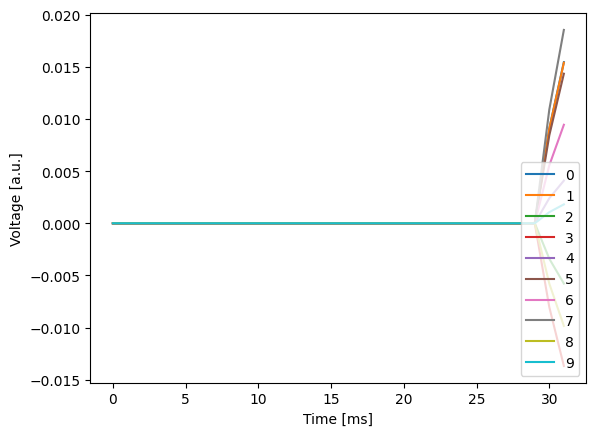

In [ ]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()

# My functions

## Final test accuracy and loss

In [ ]:
print(f"final accuracy: {accuracies[-1]}")
print(f"final loss: {training_losses[-1]}")

final accuracy: 96.69
final accuracy: 0.2108622044324875


# Summary - write to csv

In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
y_pred = preds_ints
y_test = true_ints
target_names = ['0','1','2','3','4','5','6','7','8','9']
precisions = []
recalls = []
f1_scores = []

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import classification_report
print('\nClassification Report\n')
classifi_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
# print(classifi_report)

#macro avg
macro_prec = precision_score(y_test, y_pred, average='macro')

macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1_score = f1_score(y_test, y_pred, average='macro')


precisions.append(macro_prec)
recalls.append(macro_recall)
f1_scores.append(macro_f1_score)

#Classification report to pandas dataframe
classifi_report_df = pd.DataFrame(classifi_report)
# print(classifi_report_df)

In [ ]:
import pandas as pd
from google.colab import drive
# test_losses.append(test_loss)
# accuracies.append(accuracy)
# time_per_epoch.append(t.get_execution_time())
drive.mount('/content/drive/')

precisions.append(macro_prec)
recalls.append(macro_recall)
f1_scores.append(macro_f1_score)

framework_name = "Norse"

def save_to_csv(acc : list, loss : list, times : list, precisions : list, recalls : list, f1_scores : list):
  data = pd.DataFrame(np.array([acc, loss, times, precisions, recalls, f1_scores]),
                   columns=['accuracies', 'loss', 'time_per_epoch', 'precision (macro)','recalls', 'f1_scores' ])
  data.to_excel("/content/drive/My Drive/" + framework_name + ".xlsx")
  print("Successfully uploaded to google drive")           


save_to_csv(accuracies, test_losses, time_per_epoch)

#Save classification report to drive
classifi_report_df.to_excel("/content/drive/My Drive/" + framework_name + "classifi_report" + ".xlsx")




Mounted at /content/drive/


ValueError: ignored

# Confusion Matrix

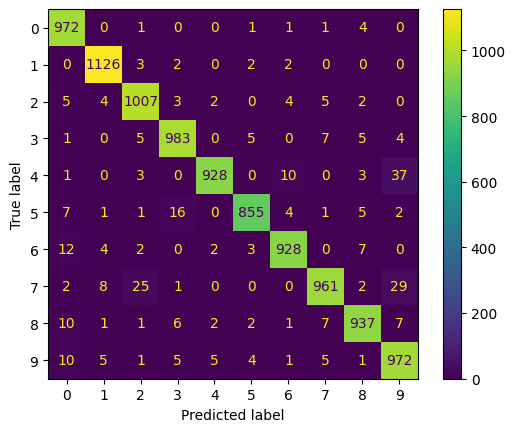

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay(cm).plot()


In [ ]:
print(cm)

[[ 972    0    1    0    0    1    1    1    4    0]
 [   0 1126    3    2    0    2    2    0    0    0]
 [   5    4 1007    3    2    0    4    5    2    0]
 [   1    0    5  983    0    5    0    7    5    4]
 [   1    0    3    0  928    0   10    0    3   37]
 [   7    1    1   16    0  855    4    1    5    2]
 [  12    4    2    0    2    3  928    0    7    0]
 [   2    8   25    1    0    0    0  961    2   29]
 [  10    1    1    6    2    2    1    7  937    7]
 [  10    5    1    5    5    4    1    5    1  972]]
